In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import claude.utils as cu
from claude.tx import qammod
from claude.models.NLIN import defaultParameters,\
                               calcAseNoisePower,\
                               calcIntraConstants,calcInterConstants,\
                               calcIntraConstantsAddTerms,calcInterConstantsAddTerms,\
                               calcIntraChannelNLIN,calcInterChannelNLIN,calcInterChannelNLINAddTerms,\
                               calcIntraChannelGN,calcInterChannelGN

In [2]:
# System parameters
param = defaultParameters()
param.nSpans = 20

param.M = 64
constellation = qammod(param.M)

power = np.mean(np.abs(constellation)**2)
param.kur  = np.mean(np.abs(constellation)**4) / power**2
param.kur3 = np.mean(np.abs(constellation)**6) / power**3

print( param )

nPol:	2
lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
D:	16.464
alpha:	0.2
beta2:	2.0999953937404486e-26
gamma:	1.3
nSpans:	20
spanLength:	100
noiseFigure:	5
PdBm:	1
Rs:	32
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
chSpacing:	50
kur:	1.3809523809523807
kur3:	2.225785552316164
N_mc:	1000000
PD:	0
M:	64



In [3]:
# Calculate System constants
# Calculate Add terms
chi = np.zeros( (2, param.nChannels-1) )
intraConstAdd = np.zeros( (5, param.nChannels-1) )
interConstAdd = np.zeros( (4, param.nChannels-1) )

skip = 0
for ii,channel in enumerate(param.channels):
    if np.abs(channel) < 1e-6:
        skip = 1
        continue
    param.chSpacing = channel
    chi[:,ii-skip] = calcInterConstants(param)
    intraConstAdd[:,ii-skip] = calcIntraConstantsAddTerms(param)
    interConstAdd[:,ii-skip] = calcInterConstantsAddTerms(param)
    
X = calcIntraConstants(param)
calcAseNoisePower = calcAseNoisePower(param)

In [4]:
# Sweep power and calculate different NLIN and GN interference
powerSweep = np.arange(-10,6)
NLINinter = np.zeros(powerSweep.shape)
NLINintra = np.zeros(powerSweep.shape)

NLINinterAdd = np.zeros(powerSweep.shape)
NLINintraAdd = np.zeros(powerSweep.shape)

GNinter = np.zeros(powerSweep.shape)
GNintra = np.zeros(powerSweep.shape)

for ii,PdBm in enumerate(powerSweep):
    param.PdBm = PdBm
    NLINinter[ii] = np.sum( calcInterChannelNLIN(chi,param) )
    NLINintra[ii] = calcIntraChannelNLIN(X,param)[0]
    
    NLINinterAdd[ii] = np.sum( calcInterChannelNLINAddTerms(interConstAdd,param) )
    NLINintraAdd[ii] = np.sum( calcIntraChannelNLIN(intraConstAdd,param) )
    
    GNinter[ii] = np.sum( calcInterChannelGN(chi,param) )
    GNintra[ii] = calcIntraChannelGN(X,param)[0]

In [5]:
# effective SNR
NLINeffSNR = powerSweep - cu.lin2dB( calcAseNoisePower+NLINinter+NLINintra+NLINinterAdd+NLINintraAdd, 'dBm')
GNeffSNR = powerSweep - cu.lin2dB( calcAseNoisePower+GNinter+GNintra, 'dBm')

In [6]:
# Nonlinear Wizard http://nlinwizard.eng.tau.ac.il
wizard_powerSweep = [-10, -8, -6,-4, -2, 0, 2, 4]
wizard_effSNR = [5.91, 7.90, 9.88, 11.80, 13.49, 14.43, 13.73, 11.20]

In [7]:
# Fehenberger GN https://www.fehenberger.de/#sourcecode
fehen_powerSweep = [-10, -8, -6, -4, -2, 0, 2, 4]
fehen_effSNR = [5.9016, 7.8922, 9.8550, 11.7102, 13.1774, 13.5348, 12.0059, 8.9346]

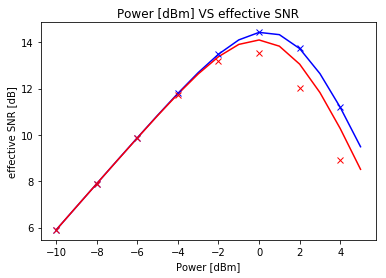

In [8]:
plt.plot(powerSweep, NLINeffSNR,'b')
plt.plot(powerSweep, GNeffSNR,'r')
plt.plot(wizard_powerSweep, wizard_effSNR,'bx')
plt.plot(fehen_powerSweep, fehen_effSNR,'rx')
plt.title('Power [dBm] VS effective SNR')
plt.xlabel('Power [dBm]')
plt.ylabel('effective SNR [dB]')
plt.show()